In [1]:
from datetime import datetime
import time,pytz
import os, glob, subprocess, sys, uuid
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

2025-09-02 11:20:06.966396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756799407.057417   10387 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756799407.088178   10387 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-02 11:20:14.031649: E tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:55] The TF_FORCE_GPU_ALLOW_GROWTH environment variable is set but could not be parsed: "1". Valid values are "true" or "false". Using original config value of 1.
I0000 00:00:1756799414.033066   10387 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Lapto

In [2]:
# ========== LOAD & CLEAN ==========
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

files = [
    ("data/processed.cleveland.data", "cleveland"),
    ("data/processed.hungarian.data", "hungarian"),
    ("data/processed.switzerland.data", "switzerland"),
    ("data/processed.va.data", "va")
]

# Load data with source tracking
dfs = []
for file_path, source in files:
    temp_df = pd.read_csv(file_path, names=column_names, na_values='?', header=None)
    temp_df['source'] = source
    dfs.append(temp_df)

df = pd.concat(dfs, ignore_index=True)

# Convert columns to numeric, binarize target
for col in column_names:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(df.describe())

              age         sex          cp  ...          ca        thal      target
count  920.000000  920.000000  920.000000  ...  309.000000  434.000000  920.000000
mean    53.510870    0.789130    3.250000  ...    0.676375    5.087558    0.553261
std      9.424685    0.408148    0.930969  ...    0.935653    1.919075    0.497426
min     28.000000    0.000000    1.000000  ...    0.000000    3.000000    0.000000
25%     47.000000    1.000000    3.000000  ...    0.000000    3.000000    0.000000
50%     54.000000    1.000000    4.000000  ...    0.000000    6.000000    1.000000
75%     60.000000    1.000000    4.000000  ...    1.000000    7.000000    1.000000
max     77.000000    1.000000    4.000000  ...    3.000000    7.000000    1.000000

[8 rows x 14 columns]


  Selector      Model  Accuracy  Precision   Recall  F1 Score      AUC                                                                          Selected Features
       PCA        SVM  0.842391   0.841121 0.882353  0.861244 0.922884                                        [PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10]
       PCA   Stacking  0.853261   0.871287 0.862745  0.866995 0.922406                                        [PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10]
       PCA     Voting  0.864130   0.866667 0.892157  0.879227 0.920971                                        [PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10]
      Chi2   Stacking  0.847826   0.870000 0.852941  0.861386 0.918161         [sex, cp, thalach, exang, slope, ca, thal, src_hungarian, src_switzerland, src_va]
   ReliefF   Stacking  0.869565   0.897959 0.862745  0.880000 0.917862 [exang, cp, ca, thal, oldpeak, src_hungarian, chol, src_cleveland, slope, src_switzerland]
   ReliefF     Voting  0.858

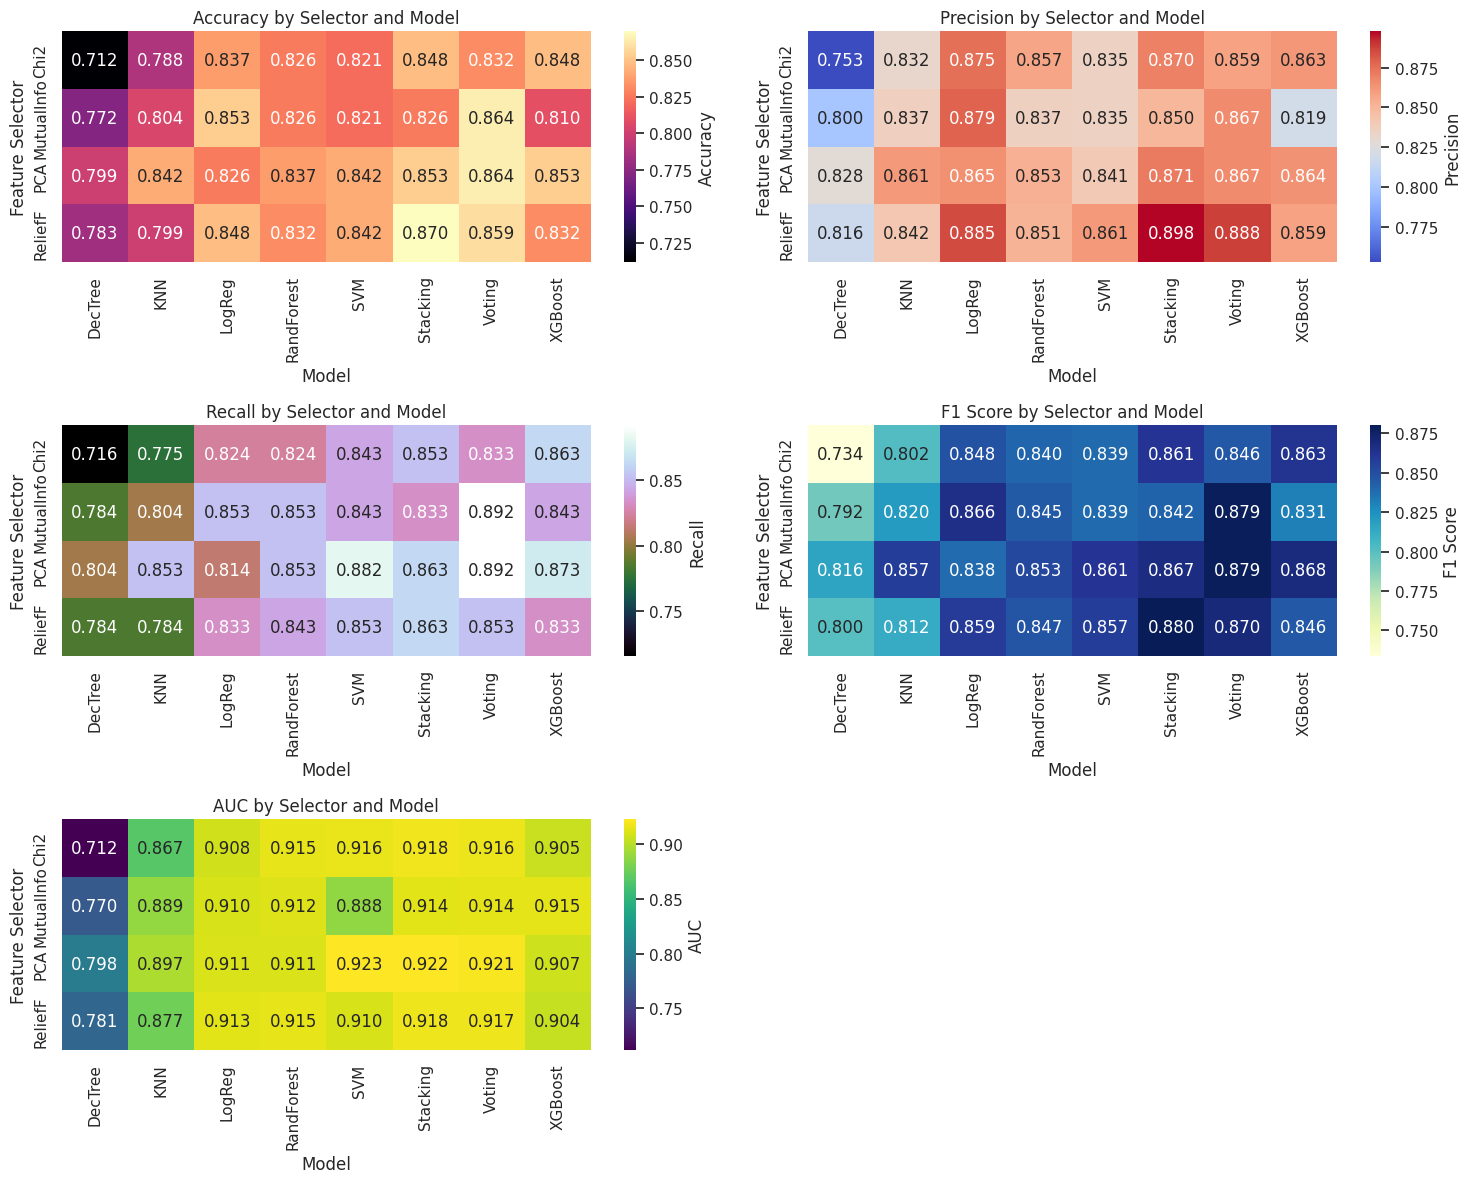

In [3]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from skrebate import ReliefF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from sklearn.ensemble import VotingClassifier, StackingClassifier

# ========== IMPUTATION ==========
dfs_imputed = []
for source in df['source'].unique():
    temp = df[df['source'] == source].copy()
    numeric_cols = temp.select_dtypes(include=[np.number]).columns.drop('target')
    imputer = KNNImputer(n_neighbors=min(5, len(temp)-1))
    temp[numeric_cols] = imputer.fit_transform(temp[numeric_cols])
    dfs_imputed.append(temp)

df = pd.concat(dfs_imputed, ignore_index=True)
df = pd.get_dummies(df, columns=['source'], prefix='src')
df = df.fillna(df.median())

# ========== SPLIT ==========
X = df.drop('target', axis=1)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=GLOBAL_RANDOM_SEED
)

# ========== VOTING & STACKING CLASSIFIERS ==========
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
]

voting_clf = VotingClassifier(
    estimators=base_learners,
    voting='soft',      # average predicted probabilities
    n_jobs=-1
)

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    passthrough=True,   # pass original features plus base predictions to final layer
    cv=5,
    n_jobs=-1
)

# ========== MODELS & SELECTORS ==========
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "DecTree": DecisionTreeClassifier(),
    "RandForest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Voting": voting_clf,
    "Stacking": stacking_clf
}

selectors = {
    # "Chi2": [("nonneg_shift", FunctionTransformer(lambda x: x - x.min(axis=0))), ("select", SelectKBest(chi2))],
    # "MutualInfo": [("select", SelectKBest(mutual_info_classif))],
    # "ReliefF": [("select", ReliefF())],
    # "PCA": [("reduce", PCA())],
    "Chi2": [("nonneg_shift", FunctionTransformer(lambda x: x - x.min(axis=0))), ("select", SelectKBest(chi2, k=10))],
    "MutualInfo": [("select", SelectKBest(mutual_info_classif, k=9))],
    "ReliefF": [("select", ReliefF(n_features_to_select=9))],
    "PCA": [("reduce", PCA(n_components=10))] # forcing PCA to select only 10 made its AUC ~1.1% more accurate
}


# ========== PIPELINES, TRAIN and EVALUATION ==========
results = []

for sel_name, sel_steps in selectors.items():
    for model_name, model in models.items():
        steps = [("scaler", StandardScaler())] + sel_steps + [("smote", SMOTE(random_state=42)), ("model", model)]
        pipe = ImbPipeline(steps)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)


        # Extract feature names
        try:
            if sel_name == "Chi2":
                mask = pipe.named_steps["select"].get_support()
                selected_features = X_train.columns[mask].tolist()
            elif sel_name == "MutualInfo":
                mask = pipe.named_steps["select"].get_support()
                selected_features = X_train.columns[mask].tolist()
            elif sel_name == "ReliefF":
                mask = pipe.named_steps["select"].top_features_[:10]
                selected_features = X_train.columns[mask].tolist()
            elif sel_name == "PCA":
                selected_features = [f"PC{i+1}" for i in range(pipe.named_steps["reduce"].n_components_)]
        except Exception as e:
            selected_features = [f"[Error extracting features: {str(e)}]"]

        results.append({
            "Selector": sel_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "AUC": auc,
            "Selected Features": selected_features
        })

# ========== SUMMARY ==========
df_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
print(df_results.sort_values(by="AUC", ascending=False).to_string(index=False))

# ========== HITMAPS ==========
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
cmap_dict = {
    "Accuracy": "magma",
    "Precision": "coolwarm",
    "Recall": "cubehelix",
    "F1 Score": "YlGnBu",
    "AUC": "viridis"
}

plt.figure(figsize=(15, 12))
sns.set_theme(style="whitegrid")

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_matrix = df_results.pivot(index="Selector", columns="Model", values=metric)
    sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap=cmap_dict[metric], cbar_kws={'label': metric})
    plt.title(f"{metric} by Selector and Model")
    plt.xlabel("Model")
    plt.ylabel("Feature Selector")

plt.tight_layout()
plt.show()

Features like `["cp", "exang", "thalach", "ca", "thal", "oldpeak", "slope"]` appear often across all methods → high predictive value.